# analyzed single drifter processed (filtered, broken into sequence)

In [1]:
import os
from glob import glob

from dask.distributed import Client
import xarray as xr
import numpy as np
from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.drifters as edr

data_dir = '/work/ALT/swot/aval/syn/drifters/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=3, walltime='12:00:00', memory='20GB')
#cluster = PBSCluster(cores=1, walltime='01:00:00', memory='20GB')
w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
client = Client(cluster)
#client = Client()

In [4]:
cluster

In [5]:
def drop(ds, ndrop):
    vdrop = list(ds)
    for v in ndrop:
        vdrop.remove(v)
    return ds.drop(vdrop)

---

## load data

In [16]:
ds = xr.open_mfdataset(data_dir+'single_tfilt/low_inertial_*.nc', 
                       concat_dim='index', parallel=True)

In [15]:
#client.restart()

In [17]:
ds = ds.persist()

In [18]:
ds = ds.chunk({'index': 1000}).persist()

In [37]:
#ds = ds.drop('pair') # try to see if this breaks stacking further below
#ds = ds.chunk({'index': 1e4})
#ds.to_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr', mode='w')

---

In [19]:
#ds = ds.persist()
ds.to_zarr(data_dir+'single_tfilt/filtered_sequences.zarr', mode='w')
#ds = xr.open_zarr(data_dir+'single_tfilt/filtered_sequences.zarr')

In [21]:
print('Dataset size = %.1f GB '%(ds.nbytes/1e9))
ds

Dataset size = 2.4 GB 


<xarray.Dataset>
Dimensions:           (TIME: 721, index: 11327)
Coordinates:
  * TIME              (TIME) timedelta64[ns] 00:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    LON               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    U                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    V                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    LAT_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    LON_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    U_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    V_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    DROGU

---

In [40]:
ndrop = ['v%d'%d for d in range(3)]
ndrop += ['U','V','LON','LAT']
ndrop += [v+'_low' for v in ['U','V']]
ndrop += [v+'_inertial' for v in ['U','V']]
ndrop += ['ID']

#ds = drop(ds,ndrop)

In [22]:
#ds = ds.persist()

---
## derives basic statistics: 

- averaged distance travelled over time block

- averaged location distribution

In [23]:
start = ds.isel(TIME=0)
end = ds.isel(TIME=-1)
d_travelled = (edr.haversine(start.LON, start.LAT, 
                             end.LON, end.LAT)
                      .rename('d_travelled').persist())

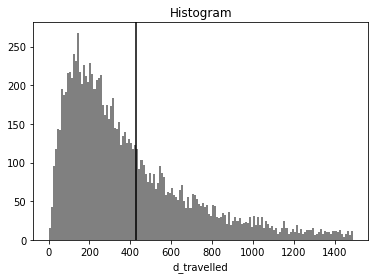

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
_, _, _ = d_travelled.plot.hist(ax=ax, bins=np.arange(0.,1.5e3,10.), color='0.5')
ax.axvline(x=d_travelled.mean(),color='k')

---

## spectra

In [26]:
ds.TIME.size

721

In [40]:
def _get_E(x, ufunc=True, **kwargs):
    #ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.periodogram(x, fs=24., axis=-1, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        Nb = v.TIME.size
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['TIME']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [41]:
f, Eu = get_E(ds.U.isel(index=0))

In [42]:
Eu = get_E(ds.U.fillna(0.), f)

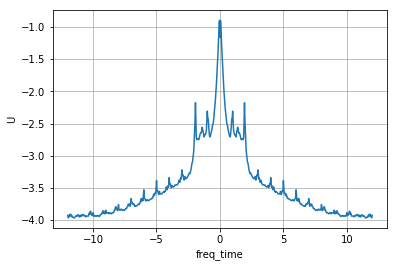

In [45]:
fig, ax = plt.subplots(1,1)
np.log10(Eu.mean('index')).plot(ax=ax)
ax.grid()

In [53]:
latb = np.arange(-70.,70.,1.)
latc = (latb[:-1]+latb[1:])*.5

#ds['LAT_mean'] = (ds.LAT.mean('TIME')+0.*ds.LAT).rename('LAT_mean')
ds['LAT_mean'] = ds.LAT.mean('TIME')
Eu_zav = Eu.groupby_bins(ds.LAT_mean, bins=latb).mean(dim=['index'])

<xarray.DataArray 'U' (LAT_mean_bins: 139, freq_time: 721)>
dask.array<shape=(139, 721), dtype=float64, chunksize=(1, 721)>
Coordinates:
  * LAT_mean_bins  (LAT_mean_bins) object (-70.0, -69.0] ... (68.0, 69.0]
  * freq_time      (freq_time) float64 -11.98 -11.95 -11.92 ... 11.95 11.98

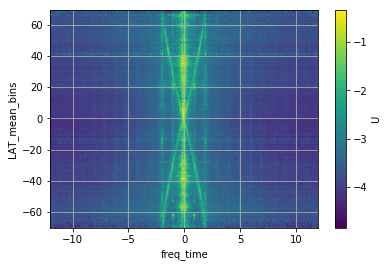

In [55]:
fig, ax = plt.subplots(1,1)
np.log10(Eu_zav).plot(ax=ax,x='freq_time',y='LAT_mean_bins')
ax.grid()

In [21]:
rb = np.arange(0.,300.,10.)
rc = (rb[:-1]+rb[1:])*.5

In [22]:
ds['r'] = ds.r.where(~np.isnan(ds.U_0_inertial*ds.U_0_low), drop=False)
#mask = xr.where(np.isnan(ds.LON_0_inertial*ds.LON_0_low), 0, 1)
#ds.r = ds.r*mask

In [23]:
N_r = edr.bin1d(ds.r, ds.r, rb, False, bin_dim='rb', name='N_r')
N_r = N_r.sum('index')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [24]:
latb = np.arange(-70.,70.,1.)
latc = (latb[:-1]+latb[1:])*.5
lonb = np.arange(-180.,180.,1.)
lonc = (lonb[:-1]+lonb[1:])*.5

In [25]:
ll = edr.bin2d(ds.r, ds.LON_0, lonb, ds.LAT_0, latb, False, bin_dim1='lonb', bin_dim2='latb', name='Ncount')
ll = ll.sum('index')

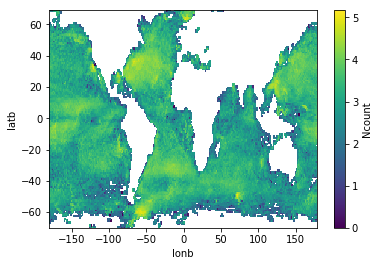

In [26]:
np.log10(ll).plot(x='lonb', y='latb')

---

## plot selected trajectories

In [27]:
lds = ds.isel(index=slice(0,2000)).persist()

In [28]:
rmean = lds.r.mean('TIME').persist()
#U02_inertial_mean = (lds.U_0_inertial**2).mean('TIME').persist()
U_inertial = np.abs(lds.U_0_inertial).mean('TIME').persist()

In [29]:
#lds = lds.where( (rmean<105) & (rmean>95) , drop=True)
lds = lds.where( U_inertial>.1 , drop=True)
lds

<xarray.Dataset>
Dimensions:       (TIME: 721, index: 99)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    U_0           (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    V_0           (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    v0_0          (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    v1_0          (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    v2_0          (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    LAT_1         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    LON_1         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 

In [30]:
#del lds

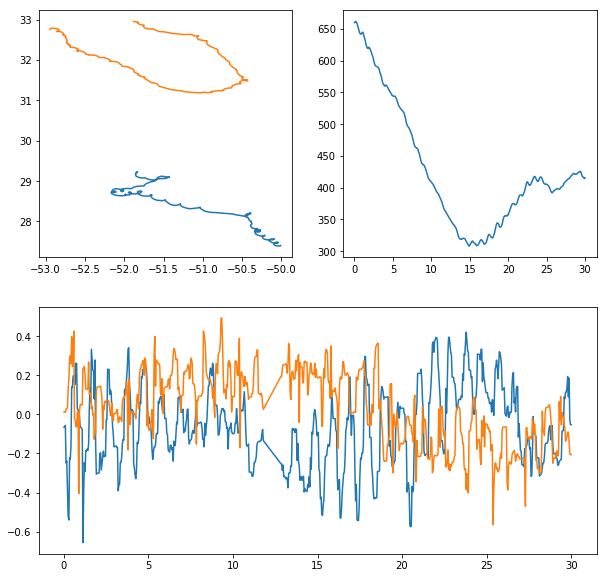

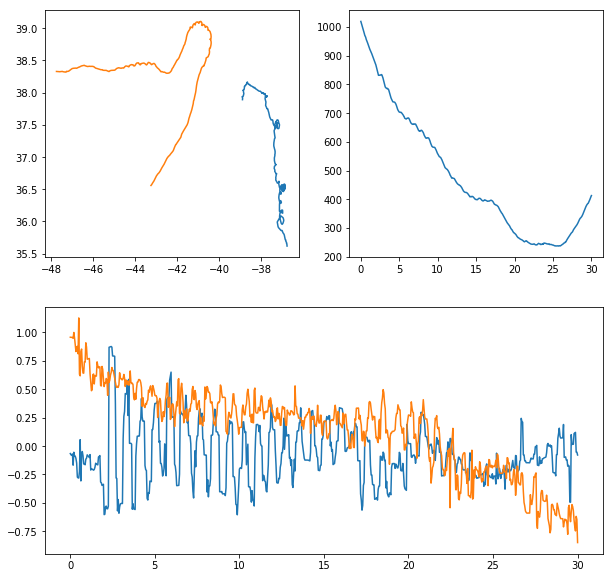

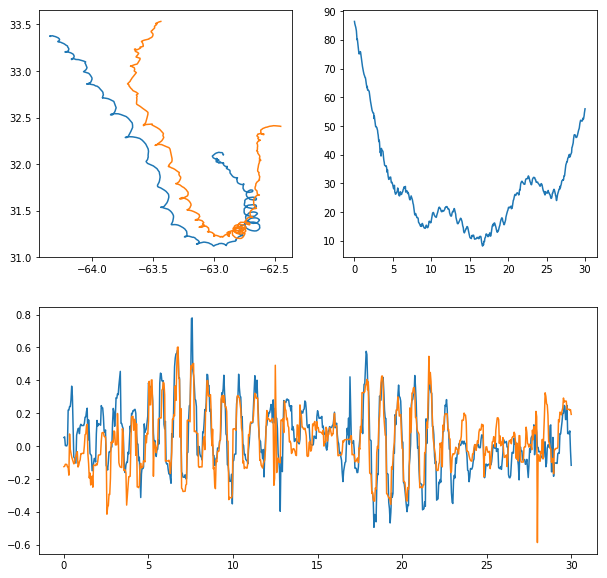

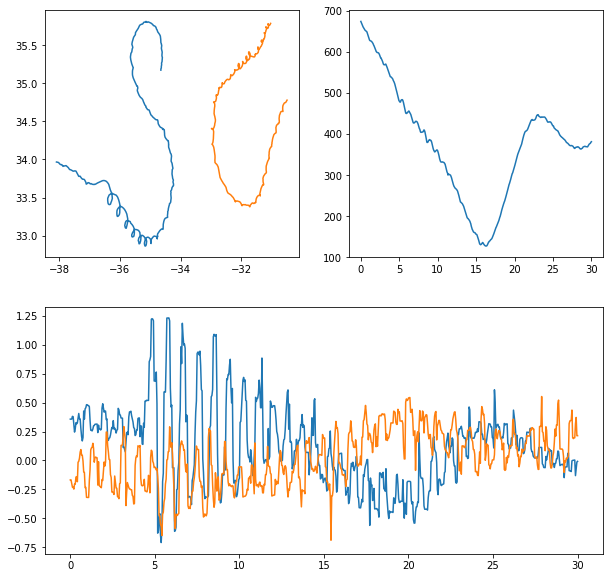

In [34]:
def plot_trajectories(ds):
    t = ds.TIME/np.timedelta64(1, 'D')
    for i in ds.index:
        lds = ds.sel(index=i)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(221)
        ax.plot(lds.LON_0, lds.LAT_0, label='0')
        ax.plot(lds.LON_1, lds.LAT_1, label='1')
        ax = fig.add_subplot(212)
        ax.plot(t,lds.U_0, label='0')
        ax.plot(t,lds.U_1, label='1')
        ax = fig.add_subplot(222)
        ax.plot(t,lds.r,label='r')
        #print(lds.lon_1.values)
        
plot_trajectories(lds.isel(index=slice(0,4)))

---
## computations of decorrelation length scales for velocity

In [35]:
def get_UV_prod(N_r, band=''):
    ods = N_r.to_dataset()
    if band != '':
        suff = '_'+band
    else:
        suff = band
    #
    for u0 in ['U', 'V']:
        for u1 in ['U', 'V']:
            ods[u0+'0'+u1+'1'+suff] = (edr.bin1d(ds[u0+'_0'+suff]*ds[u1+'_1'+suff], ds.r, rb, 
                                   True, bin_dim='rb')
                                  .sum('index')/ods.N_r)
    for i in ['0','1']:
        for u in ['U','V']:
            ods[u+i+u+i+suff] = (edr.bin1d(ds[u+'_'+i+suff]*ds[u+'_'+i+suff], ds.r, rb, 
                                   True, bin_dim='rb')
                            .sum('index')/ods.N_r)
    return ods

In [36]:
ds_inst = get_UV_prod(N_r)
ds_low = get_UV_prod(N_r, 'low')
ds_inertial = get_UV_prod(N_r, 'inertial')
ods = xr.merge([ds_inst, ds_low, ds_inertial]).persist()

In [37]:
ods

<xarray.Dataset>
Dimensions:        (rb: 29)
Coordinates:
  * rb             (rb) float64 5.0 15.0 25.0 35.0 ... 255.0 265.0 275.0 285.0
Data variables:
    N_r            (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0V1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0U1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0V1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U0           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0V0           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U1U1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V1V1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U1_low       (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0V1_low       (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0U1_low       (rb) float64 dask.array<s

In [38]:
def plot_band(band):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(131)

    U0U0, V0V0 = ods['U0U0'+band], ods['V0V0'+band]
    U1U1, V1V1 = ods['U1U1'+band], ods['V1V1'+band]
    U0U1, V0V1 = ods['U0U1'+band], ods['V0V1'+band]

    (U0U1/np.sqrt(U0U0*U1U1)).plot(ax=ax, label='U0U1 normalized')
    (V0V1/np.sqrt(V0V0*V1V1)).plot(ax=ax, label='V0V1 normalized')
    ax.legend()
    ax.set_ylim(0.,1.)

    ax = fig.add_subplot(132)
    np.sqrt(U0U0).plot(ax=ax, label='U0U0')
    np.sqrt(V0V0).plot(ax=ax, label='V0V0')
    np.sqrt(U1U1).plot(ax=ax, color='C0', ls='--')
    np.sqrt(V1V1).plot(ax=ax, color='C1', ls='--')
    ax.legend()
    ax = fig.add_subplot(133)
    ods.N_r.plot(ax=ax)

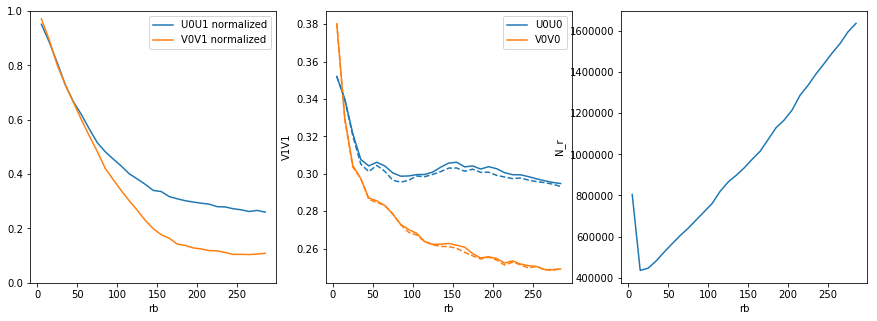

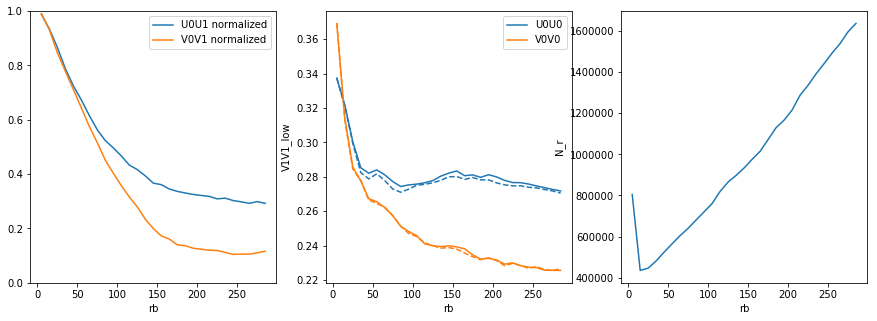

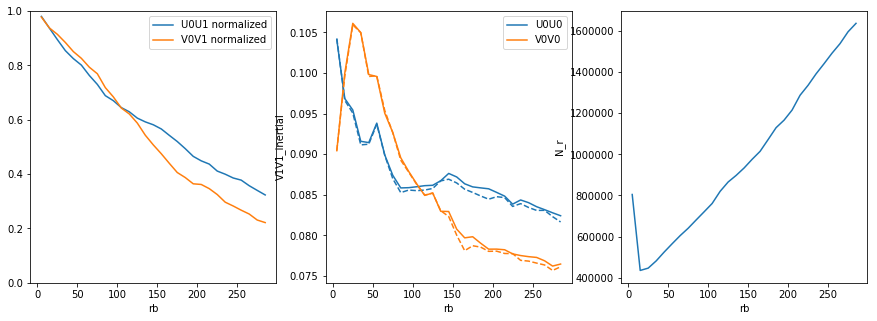

In [39]:
for band in ['','_low','_inertial']:
    plot_band(band)

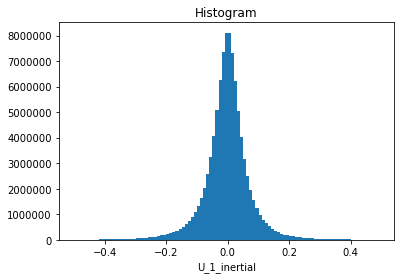

In [40]:
_ = ds['U_1_inertial'].plot.hist(bins=np.arange(-.5,.5,.01))

---

In [34]:
client.restart()

Worker tcp://10.135.36.35:37710 restart in Job 5261702. This can be due to memory issue.
Worker tcp://10.135.36.32:43072 restart in Job 5261700. This can be due to memory issue.
Worker tcp://10.135.36.39:38365 restart in Job 5261703. This can be due to memory issue.
Worker tcp://10.135.36.35:36440 restart in Job 5261702. This can be due to memory issue.
Worker tcp://10.135.36.40:35096 restart in Job 5261707. This can be due to memory issue.
Worker tcp://10.135.36.40:40446 restart in Job 5261708. This can be due to memory issue.
Worker tcp://10.135.36.39:40935 restart in Job 5261705. This can be due to memory issue.
Worker tcp://10.135.36.39:43364 restart in Job 5261706. This can be due to memory issue.
Worker tcp://10.135.36.39:34064 restart in Job 5261703. This can be due to memory issue.
Worker tcp://10.135.36.39:44824 restart in Job 5261704. This can be due to memory issue.
Worker tcp://10.135.36.32:37505 restart in Job 5261700. This can be due to memory issue.
Worker tcp://10.135.3

Client Scheduler: tcp://10.135.39.56:48612 Dashboard: http://10.135.39.56:8787/status,Cluster Workers: 10 Cores: 60 Memory: 200.00 GB


In [45]:
cluster.close()